In [47]:
import pandas as pd
import matplotlib.pyplot as plt 
import re 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold 
import seaborn as sns 

import mlflow 
import mlflow.sklearn
import dagshub
import os

In [38]:
data = pd.read_csv('/Users/merkava/Documents/School/Software engineering/SAS/data/raw/Steam.csv')
data.dropna(inplace=True)

print(data.shape)
print(f"Dataset shape: {data.shape}")



(17316, 5)
Dataset shape: (17316, 5)


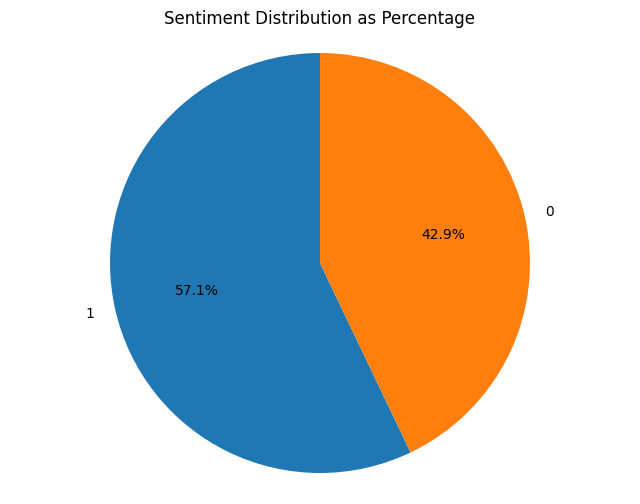

In [39]:
balance = data['user_suggestion'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(balance, labels=balance.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution as Percentage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [40]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize text
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)


[nltk_data] Downloading package punkt to /Users/merkava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/merkava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
data['cleaned_review'] = data['user_review'].apply(preprocess_text)

# Extract features and target variables
X = data['cleaned_review']
y = data['user_suggestion']  
# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
  scores = analyzer.polarity_scores(text)
  return scores['compound']

def plot_wordclouds(df):

  # Combine all reviews for each sentiment
  positive_reviews = " ".join(df[df['user_suggestion'] == 1]['cleaned_review'])
  negative_reviews = " ".join(df[df['user_suggestion'] == 0]['cleaned_review'])

  positive_word_scores = {word: get_sentiment_score(word) for word in positive_reviews.split()}
  negative_word_scores = {word: get_sentiment_score(word) for word in negative_reviews.split()}

  # Create WordCloud objects
  #positive_word_counts = Counter(positive_reviews.split())
  negative_word_counts = Counter(negative_reviews.split())

  # Create WordCloud objects with frequency and sentiment score weighting
  wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                                  stopwords=STOPWORDS).generate_from_frequencies(positive_word_scores)

  # Filter out words with positive sentiment scores from the negative word cloud
  negative_word_scores_filtered = {word: score * negative_word_counts[word] 
                                   for word, score in negative_word_scores.items() if score < 0}

  wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                                  stopwords=STOPWORDS).generate_from_frequencies(negative_word_scores_filtered)
  # Display the generated images
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(wordcloud_positive, interpolation='bilinear')
  plt.title('Positive Reviews')
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(wordcloud_negative, interpolation='bilinear')
  plt.title('Negative Reviews')
  plt.axis("off")

  plt.show()

plot_wordclouds(data)


KeyboardInterrupt: 

In [43]:
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [49]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'djamesdean'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '8e009ed06f4ac66d34599916803055c698bbb9bf'

dagshub.init(repo_owner='Djamesdean', repo_name='SAS-MLFLOW', mlflow=True)

# Set MLflow Tracking URI (Modify this if using a remote MLflow server)
mlflow.set_tracking_uri("https://dagshub.com/Djamesdean/SAS-MLFLOW.mlflow")  # Change if running MLflow server elsewhere

# Set Experiment Name
mlflow.set_experiment("steam_reviews_sentiment")

Initialized MLflow to track repo "Djamesdean/SAS-MLFLOW"

Repository Djamesdean/SAS-MLFLOW initialized!

2025/02/03 10:26:33 INFO mlflow.tracking.fluent: Experiment with name 'steam_reviews_sentiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/5875608e0d36417face2d067350632a7', creation_time=1738574793692, experiment_id='0', last_update_time=1738574793692, lifecycle_stage='active', name='steam_reviews_sentiment', tags={}>

In [50]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluates and logs model performance to MLflow."""
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Log metrics to MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_positive", report['1']['precision'])
    mlflow.log_metric("recall_positive", report['1']['recall'])
    mlflow.log_metric("f1_score_positive", report['1']['f1-score'])
    mlflow.log_metric("precision_negative", report['0']['precision'])
    mlflow.log_metric("recall_negative", report['0']['recall'])
    mlflow.log_metric("f1_score_negative", report['0']['f1-score'])

In [51]:
def train_naive_bayes():
 with mlflow.start_run(): 
    nb_model = MultinomialNB()

    param_grid = {'alpha': [0.01, 0.1, 1]}

    grid_search = GridSearchCV(nb_model, param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_

    y_pred = grid_search.predict(X_test_tfidf)
    evaluate_model(y_test, y_pred, "Naive Bayes")

    nb_probabilities = best_model.predict_proba(X_test_tfidf)
    print("Naive Bayes Probabilities for each class (first 5 samples):\n", nb_probabilities[:5])
        # Log parameters
        
    for param, value in grid_search.best_params_.items():
            mlflow.log_param(param, value)

        # Log the trained model
    mlflow.sklearn.log_model(best_model, "Naive Bayes")

        # Register the model in MLflow Model Registry
    model_uri = f"models:/{"Naive Bayes"}/latest"
    mlflow.register_model(
       model_uri=f"runs:/{mlflow.active_run().info.run_id}/{"Naive Bayes"}",
       name="Naive Bayes"
        )
    print(f"Model {"Naive Bayes"} registered successfully.")

    return  best_model

In [53]:
def train_logistic_regression():
  with mlflow.start_run():
    lr_model = LogisticRegression(max_iter=100)
    param_grid = {'C': [0.1, 1, 10]}

    grid_search = GridSearchCV(lr_model, param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_

    y_pred = grid_search.predict(X_test_tfidf)
    evaluate_model(y_test, y_pred, "Logistic Regression")

    lr_probabilities = best_model.predict_proba(X_test_tfidf)
    print("Logistic Regression Probabilities for each class:\n", lr_probabilities[:5])

       # Log parameters
    for param, value in grid_search.best_params_.items():
            mlflow.log_param(param, value)

        # Log the trained model
    mlflow.sklearn.log_model(best_model, "Logistic Regression")

        # Register the model in MLflow Model Registry
    model_uri = f"models:/{"Logistic Regression"}/latest"
    mlflow.register_model(
            model_uri=f"runs:/{mlflow.active_run().info.run_id}/{"Logistic Regression"}",
            name="Logistic Regression"
        )
    
    return best_model


Naive Bayes Evaluation:
Accuracy: 0.828810623556582
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79      1491
           1       0.82      0.89      0.86      1973

    accuracy                           0.83      3464
   macro avg       0.83      0.82      0.82      3464
weighted avg       0.83      0.83      0.83      3464



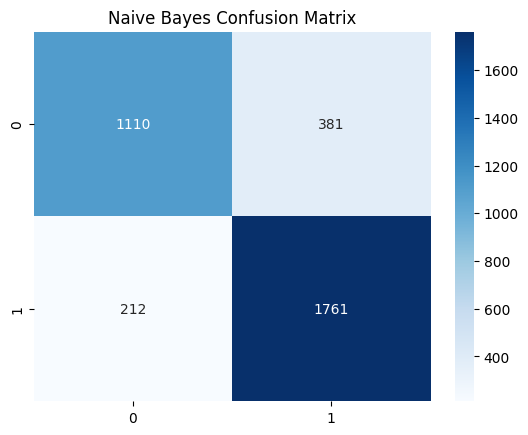

Naive Bayes Probabilities for each class (first 5 samples):
 [[0.39799261 0.60200739]
 [0.24186676 0.75813324]
 [0.50426235 0.49573765]
 [0.15420134 0.84579866]
 [0.57266076 0.42733924]]


2025/02/03 10:27:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Naive Bayes'.
2025/02/03 10:27:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Naive Bayes, version 1
Created version '1' of model 'Naive Bayes'.


Model Naive Bayes registered successfully.


2025/02/03 10:27:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-lamb-33 at: https://dagshub.com/Djamesdean/SAS-MLFLOW.mlflow/#/experiments/0/runs/fa00b76796254fcdb99c13d5d132260f.
2025/02/03 10:27:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Djamesdean/SAS-MLFLOW.mlflow/#/experiments/0.


In [52]:
nb_model = train_naive_bayes()


Logistic Regression Evaluation:
Accuracy: 0.8498845265588915
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1491
           1       0.86      0.88      0.87      1973

    accuracy                           0.85      3464
   macro avg       0.85      0.84      0.85      3464
weighted avg       0.85      0.85      0.85      3464



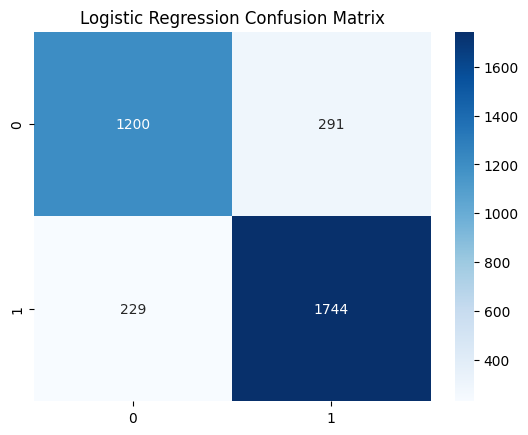

Logistic Regression Probabilities for each class:
 [[0.41645685 0.58354315]
 [0.30974536 0.69025464]
 [0.69793791 0.30206209]
 [0.15250706 0.84749294]
 [0.09855356 0.90144644]]


2025/02/03 13:00:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression'.
2025/02/03 13:00:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression, version 1
Created version '1' of model 'Logistic Regression'.
2025/02/03 13:00:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-roo-888 at: https://dagshub.com/Djamesdean/SAS-MLFLOW.mlflow/#/experiments/0/runs/cad3e18ce6b44fad89a61464e618c402.
2025/02/03 13:00:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Djamesdean/SAS-MLFLOW.mlflow/#/experiments/0.


In [54]:
lr_model = train_logistic_regression()